In [ ]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [50, 10]

In [22]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")
    return image

def capture_image_from_camera():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise ValueError("Unable to access the camera.")

    print("Press 's' to capture the image.")
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        cv2.imshow("Sudoku Capture", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):  # Нажмите 's', чтобы сохранить изображение
            captured_image = frame.copy()
            break
        elif key == ord('q'):  # Нажмите 'q', чтобы выйти
            cap.release()
            cv2.destroyAllWindows()
            raise ValueError("Image capture aborted by user.")

    cap.release()
    cv2.destroyAllWindows()
    return captured_image

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Пороговая обработка
    # _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)
    return threshold

def find_largest_contour(threshold):
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    peri=cv2.arcLength(largest_contour, True)
    polygone=cv2.approxPolyDP(largest_contour, 0.02*peri, True)

    return polygone

def get_rectangle_corners(polygone):
    points = sorted(np.vstack(polygone).squeeze(), key=lambda x: (x[1], x[0]))
    top_left, top_right = sorted(points[:2], key=lambda x: x[0])
    bottom_left, bottom_right = sorted(points[2:], key=lambda x: x[0])
    return top_left, top_right, bottom_right, bottom_left


marge = 4
case = 28 + 2 * marge
width = height = 9 * case

# Исправление перспективы
def perspective_transform(image, points):
    src = np.array(points, dtype=np.float32)
    destination =np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    matrix = cv2.getPerspectiveTransform(np.array(src, dtype="float32"), destination)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    return warped

# 3. Разделение на клетки
def split_into_cells(warped_image):
    height, width = warped_image.shape[:2]
    cell_height, cell_width = height // 9, width // 9
    cells = []

    for row in range(9):
        for col in range(9):
            y1, y2 = row * cell_height, (row + 1) * cell_height
            x1, x2 = col * cell_width, (col + 1) * cell_width
            cell = warped_image[y1:y2, x1:x2]
            cells.append(cell)

    return cells


def draw_grid(image):
    height, width = image.shape[:2]
    cell_height, cell_width = height // 9, width // 9

    for row in range(9):
        for col in range(9):
            y1, y2 = row * cell_height, (row + 1) * cell_height
            x1, x2 = col * cell_width, (col + 1) * cell_width
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    return image


def draw_digits(image, digits):
    height, width = image.shape[:2]
    cell_height, cell_width = height // 9, width // 9

    for row in range(9):
        for col in range(9):
            y1 = row * cell_height
            x1 = col * cell_width

            digit = digits[row * 9 + col]
            if digit != 0:
                cv2.putText(image, str(digit), (x1 + cell_width // 4, y1 + 3 * cell_height // 4),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    return image



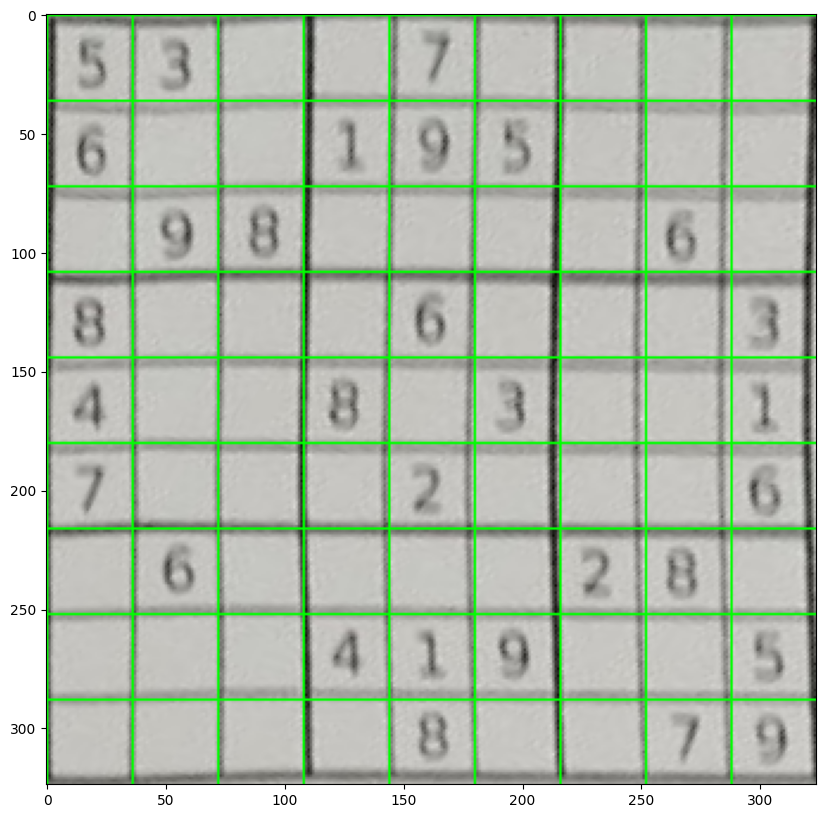

In [33]:
image_path = 'data/image_1.jpg'

image = load_image(image_path)
# image = capture_image_from_camera()
threshold = preprocess_image(image)
polygon = find_largest_contour(threshold)
corners = get_rectangle_corners(polygon)
transformed_image = perspective_transform(image, corners)
# cells = split_into_cells(transformed_image)

result_image = draw_grid(transformed_image.copy())
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
